In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import Matrix, zeros
from numpy.random import normal
from commpy.utilities  import signal_power, upsample
from commpy.modulation import Modem, QAMModem
from utils.dsp import firFilter, pulseShape, eyediagram, lowPassFIR, edc, fourthPowerFOE, dbp, CPR
from utils.models import mzm, linFiberCh, iqm, ssfm, edfa

from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from tqdm import tqdm_notebook as tqdm
from scipy import signal
import scipy.constants as const
import numba

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

In [5]:
import sympy as sp
from IPython.display import Math, display

# função para print de expressões simbólicas
def symdisp(expr, var, unit=' '):
    '''
    Latex style display of sympy expressions
    
    :param expr: expression in latex [string]
    :param var: sympy variable, function, expression.
    :param unit: string indicating unit of var [string]
    '''
    display(Math(expr+sp.latex(var)+'\;'+unit))

# Introdução às Comunicações Ópticas Coerentes

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Por-que-comunicações-ópticas-coerentes?" data-toc-modified-id="Por-que-comunicações-ópticas-coerentes?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Por que comunicações ópticas coerentes?</a></span></li><li><span><a href="#Transmissão-de-formatos-de-modulação-coerentes" data-toc-modified-id="Transmissão-de-formatos-de-modulação-coerentes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transmissão de formatos de modulação coerentes</a></span></li><li><span><a href="#Detecção-coerente-de-sinais-ópticos" data-toc-modified-id="Detecção-coerente-de-sinais-ópticos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Detecção coerente de sinais ópticos</a></span><ul class="toc-item"><li><span><a href="#Receptor-IM/DD" data-toc-modified-id="Receptor-IM/DD-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Receptor IM/DD</a></span></li><li><span><a href="#Receptor-coerente" data-toc-modified-id="Receptor-coerente-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Receptor coerente</a></span></li></ul></li><li><span><a href="#Batimento-entre-sinal-e-laser-oscilador-local-(LO)" data-toc-modified-id="Batimento-entre-sinal-e-laser-oscilador-local-(LO)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Batimento entre sinal e laser oscilador local (LO)</a></span><ul class="toc-item"><li><span><a href="#Batimentos-entre-um-sinal-e-um-oscilador-local" data-toc-modified-id="Batimentos-entre-um-sinal-e-um-oscilador-local-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Batimentos entre um sinal e um oscilador local</a></span></li><li><span><a href="#Potência-do-sinal-detectado-$s(t)$" data-toc-modified-id="Potência-do-sinal-detectado-$s(t)$-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Potência do sinal detectado $s(t)$</a></span></li></ul></li><li><span><a href="#Híbrida-$2\times-4$-90°" data-toc-modified-id="Híbrida-$2\times-4$-90°-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Híbrida $2\times 4$ 90°</a></span><ul class="toc-item"><li><span><a href="#Exemplo-de-um-circuito-fotônico-que-implementa-uma-híbrida" data-toc-modified-id="Exemplo-de-um-circuito-fotônico-que-implementa-uma-híbrida-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Exemplo de um circuito fotônico que implementa uma híbrida</a></span></li><li><span><a href="#Matriz-de-transferência-entrada-saída" data-toc-modified-id="Matriz-de-transferência-entrada-saída-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Matriz de transferência entrada-saída</a></span></li><li><span><a href="#Derivação-das-expressões-para-o-front-end-coerente" data-toc-modified-id="Derivação-das-expressões-para-o-front-end-coerente-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Derivação das expressões para o front-end coerente</a></span></li><li><span><a href="#Tipos-de-detecção-óptica-coerente" data-toc-modified-id="Tipos-de-detecção-óptica-coerente-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Tipos de detecção óptica coerente</a></span></li></ul></li><li><span><a href="#Exemplo:-detecção-coerente-de-um-laser-não-modulado" data-toc-modified-id="Exemplo:-detecção-coerente-de-um-laser-não-modulado-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exemplo: detecção coerente de um laser não-modulado</a></span></li><li><span><a href="#Transmissão-óptica-coerente" data-toc-modified-id="Transmissão-óptica-coerente-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Transmissão óptica coerente</a></span><ul class="toc-item"><li><span><a href="#Exemplo:-simulação-10G-OOK-vs-10G-BPSK" data-toc-modified-id="Exemplo:-simulação-10G-OOK-vs-10G-BPSK-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Exemplo: simulação 10G OOK vs 10G BPSK</a></span></li><li><span><a href="#Exemplo:-simulação-com-formatos-QPSK,-QAM" data-toc-modified-id="Exemplo:-simulação-com-formatos-QPSK,-QAM-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Exemplo: simulação com formatos QPSK, QAM</a></span></li></ul></li><li><span><a href="#Multiplexação-de-polarização" data-toc-modified-id="Multiplexação-de-polarização-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Multiplexação de polarização</a></span></li><li><span><a href="#Sistemas-WDM-coerentes" data-toc-modified-id="Sistemas-WDM-coerentes-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Sistemas WDM coerentes</a></span></li></ul></div>

## Por que comunicações ópticas coerentes?

* Receptores com melhor sensitividade.

* Laser sintonizáveis podem ser utilizados para detecção coerente em sistemas WDM.

* Possibilidade de compensação via DSP de efeitos distorcivos do canal óptico (dispersão cromática, PMD, etc).

* Uso de técnicas avançadas de modulação e codificação.

* Maior eficiência no uso do espectro disponível na fibra.

## Transmissão de formatos de modulação coerentes

<img src="./figuras/Tx_IQM.png" width="400">

## Detecção coerente de sinais ópticos

### Receptor IM/DD
<img src="./figuras/Rx_OOK.png" width="400">

### Receptor coerente
<img src="./figuras/hibrida_4x90.png" width="650">

In [6]:
t, ω_c, ω_lo, ϕ_lo, Δω, Δϕ = sp.symbols('t, ω_c, ω_{LO}, ϕ_{LO}, Δω, Δϕ', real=True)
P_s, P_lo, R = sp.symbols('P_s, P_{LO}, R_d', real=True, positive=True)

A = sp.Function('A', real=True)(t)
ϕ = sp.Function('ϕ', real=True)(t)

π = sp.pi
j = sp.I

**Campo elétrico da portadora óptica modulada $E_s(t)$**

In [7]:
E_s = sp.sqrt(P_s)*A*sp.exp(j*(ω_c*t + ϕ))

symdisp('E_s(t) =', E_s)

<IPython.core.display.Math object>

**Campo elétrico do laser oscilador local $E_{LO}(t)$**

In [8]:
E_lo = sp.sqrt(P_lo)*sp.exp(j*(ω_lo*t + ϕ_lo))

symdisp('E_{LO}(t) =', E_lo)

<IPython.core.display.Math object>

## Batimento entre sinal e laser oscilador local (LO)

$$
\begin{aligned}
I_1(t) &= R_d\left|E_s(t) + jE_{LO}(t) \right|^2 \nonumber\\
       &= R_d\left[E_s(t) + jE_{LO}(t) \right]\left[E_s^*(t) - jE_{LO}^*(t) \right] \nonumber\\
       &= R_d\left[E_s(t)E_s^*(t) + jE_{LO}(t)E_s^*(t) - jE_s(t)E_{LO}^*(t) -j^2E_{LO}(t)E_{LO}^*(t) \right] \nonumber\\
       &= R_d\left[A^2P_s + jE_{LO}(t)E_s^*(t) - jE_s(t)E_{LO}^*(t) + P_{LO}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + R_d\left[ jE_{LO}(t)E_s^*(t) +(jE_{LO}(t)E_s^*(t))^* \right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + R_d 2\operatorname{Re}\left[jE_{LO}(t)E_s^*(t)\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_d\operatorname{Re}\left[j\sqrt{P_{LO}}e^{j(ω_{LO}t + ϕ_{LO})}A\sqrt{P_{s}}e^{-j(ω_ct + ϕ)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{Re}\left[je^{j(ω_{LO}t + ϕ_{LO})}e^{-j(ω_ct + ϕ)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{Re}\left[e^{j(ω_{LO}t -ω_ct + ϕ_{LO}- ϕ + \pi/2)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\cos(ω_{LO}t -ω_ct + ϕ_{LO}- ϕ + \pi/2) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] - 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(ω_{LO}t -ω_ct + ϕ_{LO} - ϕ) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(ω_ct - ω_{LO}t + ϕ - ϕ_{LO}) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(\Delta ωt + \Delta \phi) \nonumber\\
\end{aligned}
$$

em que $\Delta \omega = \omega_c - \omega_{LO}$ e $\Delta \phi = \phi - \phi_{LO}$.

### Batimentos entre um sinal e um oscilador local

**Fotocorrente $i_1(t)\propto |E_s + jE_{LO}|^2$**

In [9]:
Ei1 = (E_s + j*E_lo)/2

symdisp('E_{i_1}(t) =', Ei1)

i1 = R*sp.Abs(Ei1)**2

i1 = sp.re(i1).simplify().expand()

symdisp('i_1(t) =', i1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Fotocorrente $i_2(t) \propto |E_s - jE_{LO}|^2$**

In [10]:
Ei2 = (E_s - j*E_lo)/2

symdisp('E_{i_2}(t) =', Ei2)

i2 = R*sp.Abs(Ei2)**2

i2 = sp.re(i2).simplify().expand()

symdisp('i_2(t) =', i2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Corrente $s_Q(t) = i_1(t)-i_2(t)$**

In [11]:
sQ = i1 - i2 # saída do fotodetector balanceado

sQ = sQ.simplify()

symdisp('s_Q(t) =', sQ)

<IPython.core.display.Math object>

**Fotocorrente $i_3(t) \propto |E_s + E_{LO}|^2$**

In [12]:
Ei3 = (E_s + E_lo)/2

symdisp('E_{i_3}(t) =', Ei3)

i3 = R*sp.Abs(Ei3)**2

i3 = sp.re(i3).simplify().expand()

symdisp('i_3(t) =', i3)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Fotocorrente $i_4(t) \propto |E_s - E_{LO}|^2$**

In [13]:
Ei4 = (E_s - E_lo)/2

symdisp('E_{i_4}(t) =', Ei4)

i4 = R*sp.Abs(Ei4)**2

i4 = sp.re(i4).simplify().expand()

symdisp('i_4(t) =', i4)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Corrente $s_I(t) = i_3(t)-i_4(t)$**

In [14]:
sI = i3 - i4 # saída do fotodetector balanceado

sI = sI.simplify()

symdisp('s_I(t) =', sI)

<IPython.core.display.Math object>

**Sinal complexo detectado $s(t) = s_I(t) + js_Q(t)$**

In [15]:
s = sI + j*sQ

s = s.simplify()

symdisp('s(t) =', s)

<IPython.core.display.Math object>

### Potência do sinal detectado $s(t)$

In [16]:
Pr = sp.Abs(s)**2 # potência do sinal s(t)

symdisp('P_r(t) =', Pr)

<IPython.core.display.Math object>

## Híbrida $2\times 4$ 90°

### Exemplo de um circuito fotônico que implementa uma híbrida

<img src="./figuras/hibrida_PIC.png" width="400">

### Matriz de transferência entrada-saída

$$M=\left[\begin{array}{cccc}\frac{\sqrt{2}}{2} & \frac{\sqrt{2} j}{2} & 0 & 0 \\ \frac{\sqrt{2} j}{2} & \frac{\sqrt{2}}{2} & 0 & 0 \\ 0 & 0 & \frac{\sqrt{2}}{2} & \frac{\sqrt{2 j}}{2} \\ 0 & 0 & \frac{\sqrt{2} j}{2} & \frac{\sqrt{2}}{2}\end{array}\right]$$

$$
U=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & i
\end{array}\right]
$$

$$ T = MUM $$

### Derivação das expressões para o front-end coerente

**Matriz de transferência do acoplador 3dB**

In [17]:
C_3dB  = 1/sp.sqrt(2)*Matrix([[1, j],[j, 1]])

symdisp('C_{3dB} = ', C_3dB)

<IPython.core.display.Math object>

**Matriz de transferência da híbrida $2\times4$ 90°**

In [18]:
M = Matrix([[C_3dB, zeros(2)], [zeros(2), C_3dB]])
U = Matrix([[1, 0, 0, 0],[0, 0, 1, 0],[0, 1, 0, 0],[0, 0, 0, j]])

symdisp('M = ', M)
symdisp('U = ', U)
symdisp('T = MUM = ', M*U*M)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Derivação das expressões do *front-end* coerente com o Sympy**

In [19]:
# define funções do sympy para auxílio na derivação das expressões

# híbrida
def hybrid_2x4_90(E1, E2):
    
    M = Matrix([[C_3dB, zeros(2)], 
                [zeros(2), C_3dB]])
    
    U = Matrix([[1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 1, 0, 0],
                [0, 0, 0, j]])
    
    Ei = Matrix([[E1],[0],[0],[E2]]) # vetor 4x1
    
    Eo = M*U*M*Ei 
    
    return Eo    

# fotodetector balanceado
def bpd(E1, E2, R=1):
    
    i1 = sp.Abs(E1)**2 # |E1|^2
    i2 = sp.Abs(E2)**2 # |E2|^2
    i = i1 - i2
    
    return R*sp.re(i).simplify().expand()

In [20]:
Eo = hybrid_2x4_90(E_s, E_lo)

print('Entrada óptica da híbrida:')
symdisp('E_i = ', Matrix([[E_s],[0],[0],[E_lo]]))

Entrada óptica da híbrida:


<IPython.core.display.Math object>

In [21]:
print('Saída óptica da híbrida:')
symdisp('E_o = ', Eo)

Saída óptica da híbrida:


<IPython.core.display.Math object>

**Fotodetecção balanceada**

In [22]:
sI = bpd(Eo[1], Eo[0], R) # fotodeteccão balanceada de Eo[1] e Eo[0]
sQ = bpd(Eo[2], Eo[3], R) # fotodeteccão balanceada de Eo[2] e Eo[3]

symdisp('s_I = ', sI)
symdisp('s_Q = ', sQ)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Campo elétrico recuperado**

In [23]:
s  = sI + j*sQ
s  = s.simplify()

symdisp('s = ', s)

<IPython.core.display.Math object>

In [24]:
s = s.subs({ω_lo:ω_c + Δω, ϕ:ϕ_lo + Δϕ})

s = s.simplify().doit()

symdisp('s = ', s)

<IPython.core.display.Math object>

### Tipos de detecção óptica coerente

* **Detecção homódina (*homodyne detection*)**($\Delta\omega = 0$): a frequência do laser do transmissor e a frequência do laser oscilador local são idênticas.

* **Detecção heteródina (*heterodyne detection*)**($\Delta\omega \neq 0$): a frequência do laser do transmissor e a frequência do laser oscilador local são diferentes.

* **Detecção intradina (*intradyne detection*)**($\Delta\omega \approx 0$): a frequência do laser do transmissor e do laser oscilador local são "ligeiramente" diferentes.

**Assumindo coerência perfeita entre os lasers do transmissor e do receptor($Δω=0, ϕ_{LO}=0$)**

In [25]:
# assumindo que portadora e oscilador local estão sincronizados em fase e frequência
s = s.subs({Δω:0, Δϕ:ϕ})/(sp.sqrt(P_s)*sp.sqrt(P_lo)*R)

symdisp('s = ', s)

<IPython.core.display.Math object>

**Funções para modelagem de um receptor coerente utilizando o numpy**

In [26]:
def balancedPD(E1, E2, R=1):
    '''
    Balanced photodetector (BPD)
    
    :param E1: input field [nparray]
    :param E2: input field [nparray]
    :param R: photodiode responsivity [scalar]
    
    :return: balanced photocurrent
    '''
    assert R > 0, 'PD responsivity should be a positive scalar'
    assert E1.size == E2.size, 'E1 and E2 need to have the same size'
    
    i1 = R*E1*np.conj(E1)
    i2 = R*E2*np.conj(E2)    

    return i1-i2

def hybrid_2x4_90deg(E1, E2):
    '''
    Optical 2 x 4 90° hybrid
    
    :param E1: input signal field [nparray]
    :param E2: input LO field [nparray]
        
    :return: hybrid outputs
    '''
    assert E1.size == E2.size, 'E1 and E2 need to have the same size'
    
    # optical hybrid transfer matrix    
    T = np.array([[ 1/2,  1j/2,  1j/2, -1/2],
                  [ 1j/2, -1/2,  1/2,  1j/2],
                  [ 1j/2,  1/2, -1j/2, -1/2],
                  [-1/2,  1j/2, -1/2,  1j/2]])
    
    Ei = np.array([E1, np.zeros((E1.size,)), 
                   np.zeros((E1.size,)), E2])    
    
    Eo = T@Ei
    
    return Eo
    
def coherentReceiver(Es, Elo, Rd=1):
    '''
    Single polarization coherent optical front-end
    
    :param Es: input signal field [nparray]
    :param Elo: input LO field [nparray]
    :param Rd: photodiode resposivity [scalar]
    
    :return: downconverted signal after balanced detection    
    '''
    assert Rd > 0, 'PD responsivity should be a positive scalar'
    assert Es.size == Elo.size, 'Es and Elo need to have the same size'
    
    # optical 2 x 4 90° hybrid 
    Eo = hybrid_2x4_90deg(Es, Elo)
        
    # balanced photodetection
    sI = balancedPD(Eo[1,:], Eo[0,:], Rd)
    sQ = balancedPD(Eo[2,:], Eo[3,:], Rd)
    
    return sI + 1j*sQ

In [27]:
def phaseNoise(lw, Nsamples, Ts):
    
    σ2 = 2*np.pi*lw*Ts    
    phi = np.zeros(Nsamples)
    
    for ind in range(0, Nsamples-1):
        phi[ind+1] = phi[ind] + normal(0, np.sqrt(σ2))
        
    return phi

## Exemplo: detecção coerente de um laser não-modulado

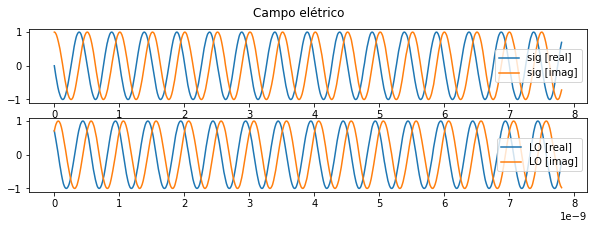

In [28]:
# parâmetros da simulação
Fa     = 128e9    # Frequência de amostragem do sinal
Ta     = 1/Fa     # Período de amostragem

Nsamples = 1000

#Pi_dBm = 10  # potência de sinal óptico na entrada do modulador em dBm
π = np.pi

#
lw = 1e6
pn_sig = phaseNoise(lw, Nsamples, Ta)
pn_lo  = phaseNoise(lw, Nsamples, Ta)

# parâmetros do sinal
Pin   = 1     # potência do laser
f_sig = 2e9   # frequência do sinal
ϕs    = π/2   # fase do laser

# parâmetros do oscilador local
Plo  = 1    # potência do oscilador local na entrada do receptor
f_lo = 2e9  # frequência do oscilador local
ϕ_lo = π/4    # fase do oscilador local

############# Simulação #############

# oscilador local
t     = np.arange(0, Nsamples)*Ta
sig   = np.sqrt(Pin)*np.exp(1j*(2*π*f_sig*t + ϕs   + pn_sig))*np.ones(t.size) # campo elétrico do sinal
sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*f_lo*t + ϕ_lo + pn_lo)) # campo elétrico do oscilador local

fig, axs = plt.subplots(2)
fig.suptitle('Campo elétrico')
axs[0].plot(t, sig.real, label = 'sig [real]')
axs[0].plot(t, sig.imag, label = 'sig [imag]')
axs[0].legend();
axs[1].plot(t, sigLO.real, label = 'LO [real]')
axs[1].plot(t, sigLO.imag, label = 'LO [imag]');
axs[1].legend();

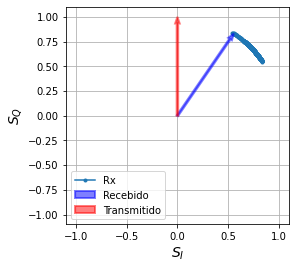

In [29]:
# receptor coerente
sigRx = coherentReceiver(sig, sigLO)

plt.figure(figsize=(4,4))
plt.plot(sigRx.real,sigRx.imag,'o-', markersize=3, label='Rx')
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.grid()

plt.arrow(0, 0, sigRx[-1].real,sigRx[-1].imag, length_includes_head=True, shape ='full',
                                         alpha = 0.5, width = 0.015, edgecolor = 'blue', 
                                         facecolor = 'blue', lw = 2, zorder = 5, label='Recebido')

plt.arrow(0, 0, sig[0].real,sig[0].imag, length_includes_head=True, shape ='full',
                                         alpha = 0.5, width = 0.015, edgecolor = 'red', 
                                         facecolor = 'red', lw = 2, zorder = 5, label='Transmitido')
plt.legend(loc='lower left');

## Transmissão óptica coerente

<img src="./figuras/sistemaCoerente.png" width="1000">

### Exemplo: simulação 10G OOK vs 10G BPSK

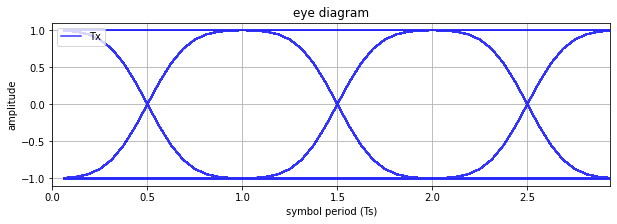

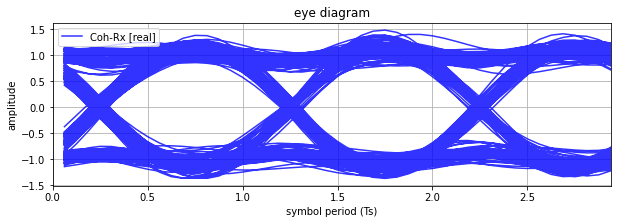

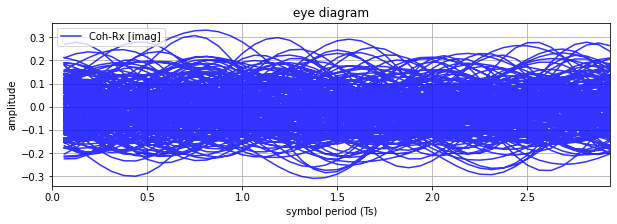

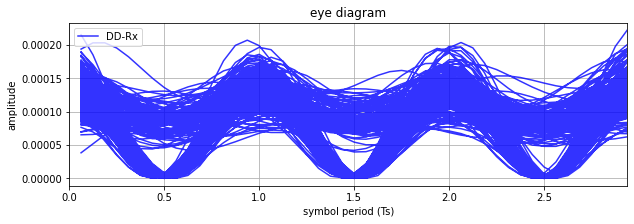

P_sig[opt] = -10.56 dBm
P_ase[opt] = -26.99 dBm
OSNR[est,Bsig] = 16.33 dB 

SNR[est] = 17.40 dB 

Total de erros contados = 0  
BER = 0.00e+00  


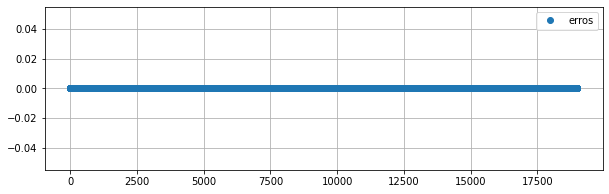

In [30]:
modulation = 'BPSK' # 'OOK', 'BPSK'

# parâmetros da simulação
SpS    = 16            # número de amostras por símbolo
Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

π = np.pi

# parâmetros do MZM
Vπ = 2

if modulation == 'OOK':
    Vb  = -Vπ/2
    Amp = 1
    Pi_dBm = -10+3.5  # potência de sinal óptico na entrada do modulador em dBm
elif modulation == 'BPSK':
    Vb = -Vπ
    Amp = 2
    Pi_dBm = -10  # potência de sinal óptico na entrada do modulador em dBm
    
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# parâmetros do receptor
B   = 10e9      # banda do receptor em Hz
Plo_dBm  = 10   # potência do oscilador local
Δf_lo = 0       # desvio de frequência do oscilador local
ϕ_lo  = 0       # fase do oscilador local

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

############# Simulação #############

### Transmissor

# gera sequência de bits pseudo-aleatórios
bitsTx   = np.random.randint(2, size=20000)    
n        = np.arange(0, bitsTx.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bitsTx-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulação óptica
Ai      = np.sqrt(Pi)
sigTxo_ = mzm(Ai, Vπ, Amp*sigTx, Vb)

# adiciona ruído ASE ao sinal óptico
σASE  = 1e-6#1e-5
ruido = normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size) + 1j*normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size)

sigTxo = sigTxo_ + ruido

### Recepcão coerente
Pin = (np.abs(sigTxo)**2).mean() # Potência óptica média média recebida

# oscilador local
t     = np.arange(0, sigTxo.size)*Ta
sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo))

# receptor coerente
sigRx = coherentReceiver(sigTxo, sigLO)
sigRx = sigRx/np.std(sigRx)

# filtragem Rx
N = 8001
h = lowPassFIR(B, Fa, N, typeF='rect')
sigRx = firFilter(h, sigRx)

# calculando a OSNR na simulação
sigTxo_Rx   = firFilter(h, sigTxo_)
sigTxo_DDRx = firFilter(h, sigTxo)
ruido_Rx    = firFilter(h, ruido)

OSNR = signal_power(sigTxo_Rx)/signal_power(ruido_Rx)

Nsamples = 10000

sigEye = sigRx.copy()
eyediagram(sigTx,  Nsamples, SpS, plotlabel = 'Tx')
eyediagram(sigEye[int(h.size/SpS)::], Nsamples, SpS, plotlabel = 'Coh-Rx')
eyediagram(np.abs(sigTxo_DDRx)**2, Nsamples, SpS, plotlabel = 'DD-Rx')

# captura amostras no meio dos intervalos de sinalização
sigRx = sigRx[0::SpS]
sigRx = sigRx/np.sqrt(signal_power(sigRx))

if modulation == 'OOK':
    symbTx = (symbTx+1)/np.sqrt(signal_power(symbTx+1))
    
# Aplica a regra de decisão ótima
bitsRx = np.empty(bitsTx.size)
bitsRx[sigRx> symbTx.mean()] = 1
bitsRx[sigRx<= symbTx.mean()] = 0

discard = 500
ind = np.arange(discard, sigRx.size-discard)

# estima SNR do sinal recebido: SNR = Es/σ^2
SNR = 1/signal_power(sigRx[ind]-symbTx[ind])

err = np.logical_xor(bitsRx[ind], 
                     bitsTx[ind])
BER = np.mean(err)

print('P_sig[opt] = %.2f dBm'%(10*np.log10(signal_power(sigTxo_)/1e-3)))
print('P_ase[opt] = %.2f dBm'%(10*np.log10(signal_power(ruido_Rx)/1e-3)))
print('OSNR[est,Bsig] = %.2f dB \n'%(10*np.log10(OSNR)))
print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

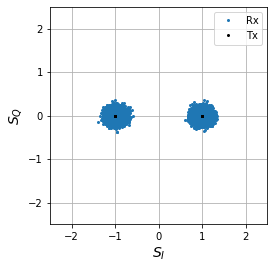

In [31]:
plt.figure(figsize=(4,4))
plt.axis('square')
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx')
plt.legend();

### Exemplo: simulação com formatos QPSK, QAM

**Modulador óptico IQ**

In [32]:
def iqm(Ai, sig, Vπ, VbI, VbQ):

    sigOut = mzm(Ai/np.sqrt(2), Vπ, sig.real, VbI) + 1j*mzm(Ai/np.sqrt(2), Vπ, sig.imag, VbQ)
    
    return sigOut

P_sig[opt] = -11.40 dBm
P_ase[opt] = -367.00 dBm
OSNR[est] = 358.61 dB 

SNR[est] = 34.67 dB 

Total de erros contados = 0  
BER = 0.00e+00  


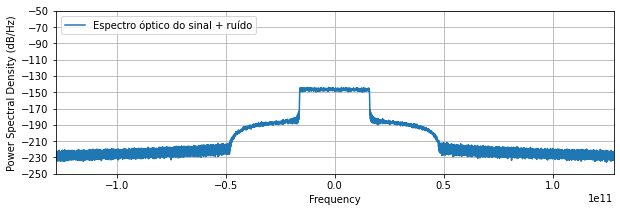

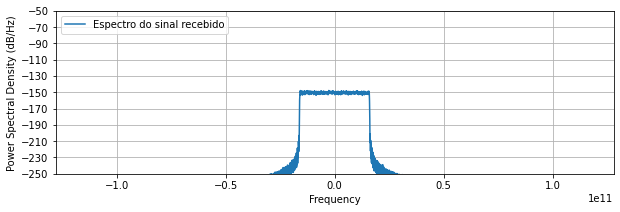

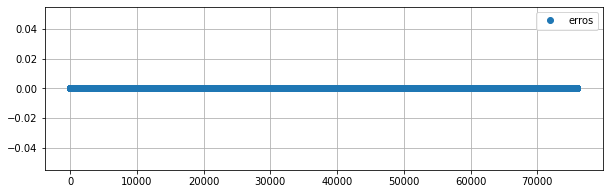

In [33]:
plotEyeDiagrams = False
plotPSD         = True

# parâmetros da simulação
M      = 16
SpS    = 16            # número de amostras por símbolo
Rs     = 32e9          # Taxa de símbolos 
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

Pi_dBm = 0  # potência de sinal óptico na entrada do modulador em dBm
π = np.pi

# parâmetros do IQM
Vπ = 2
Vb = -Vπ
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# parâmetros do canal óptico
Ltotal = 20     # km
alpha = 0.2    # dB/km
D = 16         # ps/nm/km
Fc = 193.1e12  # Hz

# parâmetros do receptor
B  = 32e9     # banda do receptor em Hz

Plo_dBm  = 10    # potência do oscilador local
Δf_lo    = 0     # desvio de frequência do oscilador local
ϕ_lo     = 0     # fase do oscilador local
lw       = 0*10e3

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

############# Simulação #############

### Transmissor

# gera sequência de bits pseudo-aleatórios
bitsTx   = np.random.randint(2, size=80000)    

# mapeia bits para símbolos QAM
mod = QAMModem(m=M)
symbTx = mod.modulate(bitsTx)
Es = mod.Es;

# normaliza energia média dos símbolos para 1
symbTx = symbTx/np.sqrt(Es)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
#pulse = pulseShape('nrz', SpS)
pulse = pulseShape('rrc', SpS, N=2048, alpha=0.01, Ts=Ts)
pulse = pulse/np.max(np.abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulação óptica
Ai      = np.sqrt(Pi)
sigTxo_ = iqm(Ai, 0.5*sigTx, Vπ, Vb, Vb)
    
# adiciona ruído ASE ao sinal óptico
σASE  = 1e-40
ruido = normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size) + 1j*normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size)

sigTxo = sigTxo_ + ruido

# calculando a OSNR na simulação
OSNR = signal_power(sigTxo_)/(signal_power(ruido)*(B/Fa))

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro óptico do sinal + ruído')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

### Canal óptico linear
sigTxo = linFiberCh(sigTxo, Ltotal, alpha, D, Fc, Fa)

### Recepcão coerente
Pin = (np.abs(sigTxo)**2).mean() # Potência óptica média média recebida

# oscilador local
t      = np.arange(0, sigTxo.size)*Ta
ϕ_pn_lo  = phaseNoise(lw, sigTxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# receptor coerente
sigRx = coherentReceiver(sigTxo, sigLO)

# filtragem Rx
N = 4001
h = lowPassFIR(B, Fa, N, typeF='rect')
sigRx = firFilter(pulse, sigRx)

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal recebido')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

# calculando a OSNR na simulação
#sigTxo_Rx   = firFilter(h, sigTxo_)
sigTxo_DDRx = firFilter(h, sigTxo)
ruido_Rx    = firFilter(h, ruido)

Nsamples = 16000
sigEye = sigRx.copy()

#visualiza diagramas de olho
if plotEyeDiagrams:
    eyediagram(sigTx,  Nsamples, SpS, plotlabel = 'Tx')
    eyediagram(sigEye, Nsamples, SpS, plotlabel = 'Coh-Rx')
    eyediagram(np.abs(sigTxo_DDRx)**2, Nsamples, SpS, plotlabel = 'DD-Rx')

# compensa dispersão cromática
sigRx = edc(sigRx, Ltotal, D, Fc, Fa)

# captura amostras no meio dos intervalos de sinalização
sigRx = sigRx[0::SpS]

discard = 2000
ind = np.arange(discard, sigRx.size-discard)

# normaliza constelação recebida
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# compensa (possível) rotação de fase adicionada pelo canal
rot = np.mean(symbTx[ind]/sigRx[ind])
sigRx  = rot*sigRx

# estima SNR da constelação recebida
SNR = signal_power(symbTx[ind])/signal_power(sigRx[ind]-symbTx[ind])

# Aplica a regra de decisão brusca        
bitsRx = mod.demodulate(np.sqrt(Es)*sigRx, demod_type = 'hard') 

err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
                     bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

print('P_sig[opt] = %.2f dBm'%(10*np.log10(signal_power(sigTxo_)/1e-3)))
print('P_ase[opt] = %.2f dBm'%(10*np.log10(signal_power(ruido_Rx)/1e-3)))
print('OSNR[est] = %.2f dB \n'%(10*np.log10(OSNR)))
print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

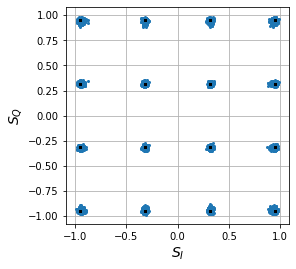

In [34]:
plt.figure(figsize=(4,4))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-1.1,1.1)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx');

## Multiplexação de polarização

<img src="./figuras/sistemaCoerentePM.png" width="900">

## Sistemas WDM coerentes

In [56]:
def simpleWDMTx(param):
    
    # transmitter parameters
    Ts  = 1/param.Rs        # symbol period [s]
    Fa  = 1/(Ts/param.SpS)  # sampling frequency [samples/s]
    Ta  = 1/Fa              # sampling period [s]
    
    # central frequencies of the WDM channels
    freqGrid = np.arange(-np.floor(param.Nch/2), np.floor(param.Nch/2)+1,1)*param.freqSpac
    
    if (param.Nch % 2) == 0:
        freqGrid += param.freqSpac/2
        
    # IQM parameters
    Ai = 1
    Vπ = 2
    Vb = -Vπ
    Pch = 10**(param.Pch_dBm/10)*1e-3   # optical signal power per WDM channel
        
    π = np.pi
    
    t = np.arange(0, int(((param.Nbits)/np.log2(param.M))*param.SpS))
    
    # allocate array 
    sigTxWDM  = np.zeros((len(t), param.Nmodes), dtype='complex')
    symbTxWDM = np.zeros((int(len(t)/param.SpS), param.Nmodes, param.Nch), dtype='complex')
    
    Psig = 0
    
    for indMode in range(0, param.Nmodes):        
        print('Mode #%d'%(indMode))
        
        for indCh in range(0, param.Nch):
            # generate random bits
            bitsTx   = np.random.randint(2, size=param.Nbits)    

            # map bits to constellation symbols
            mod = QAMModem(m=param.M)
            symbTx = mod.modulate(bitsTx)
            Es = mod.Es

            # normalize symbols energy to 1
            symbTx = symbTx/np.sqrt(Es)
            
            symbTxWDM[:,indMode,indCh] = symbTx
            
            # upsampling
            symbolsUp = upsample(symbTx, param.SpS)

            # pulse shaping
            if param.pulse == 'nrz':
                pulse = pulseShape('nrz', param.SpS)
            elif param.pulse == 'rrc':
                pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=Ts)

            pulse = pulse/np.max(np.abs(pulse))

            # formatação de pulso
            sigTx  = firFilter(pulse, symbolsUp)

            # optical modulation
            sigTxCh = iqm(Ai, 0.5*sigTx, Vπ, Vb, Vb)
            sigTxCh = np.sqrt(Pch/param.Nmodes)*sigTxCh/np.sqrt(signal_power(sigTxCh))
            
            print('channel %d power : %.2f dBm, fc : %3.4f THz' 
                  %(indCh+1, 10*np.log10(signal_power(sigTxCh)/1e-3), 
                    (param.Fc+freqGrid[indCh])/1e12))

            sigTxWDM[:,indMode] = sigTxWDM[:,indMode] + sigTxCh*np.exp(1j*2*π*(freqGrid[indCh]/Fa)*t)
            
        Psig = Psig + signal_power(sigTxWDM[:,indMode])
        
    print('total WDM signal power: %.2f dBm'%(10*np.log10(Psig/1e-3)))
    
    return sigTxWDM, symbTxWDM, freqGrid

@numba.njit
def edfa(Ei, G, nf, Fc, Fs):
    '''
    Simple EDFA model
    
    '''
    nf_lin   = 10**(nf/10)
    G_lin    = 10**(G/10)
    nsp      = (G_lin*nf_lin - 1)/(2*(G_lin - 1))
    N_ase    = (G_lin - 1)*nsp*const.h*Fc
    p_noise  = N_ase*Fs    
    noise    = np.random.normal(0, np.sqrt(p_noise), Ei.shape) + 1j*np.random.normal(0, np.sqrt(p_noise), Ei.shape)
    return Ei*np.sqrt(G_lin) + noise


def ssfm(Ein, Fs, Ltotal, Lspan, hz=0.5, alpha=0.2, gamma=1.3, D=16, Fc=193.1e12, amp='edfa', NF=4.5):      
    '''
    Split-step Fourier method (symmetric, single-pol.)
    
    '''             
    c = 299792458   # speed of light (vacuum)
    c_kms = c/1e3
    λ  = c_kms/Fc
    α  = alpha/(10*np.log10(np.exp(1)))
    β2 = -(D*λ**2)/(2*np.pi*c_kms)
    γ  = gamma
            
    Nfft = len(Ein)

    ω = 2*np.pi*Fs*fftfreq(Nfft)
    
    Nspans = int(np.floor(Ltotal/Lspan))
    Nsteps = int(np.floor(Lspan/hz))
    
    Ech = Ein.reshape(len(Ein),)  
      
    linOperator = np.exp(-(α/2)*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))
    
    for spanN in tqdm(range(1, Nspans+1)):   
        Ech = fft(Ech) #single-polarization field
        
        # fiber propagation step
        for stepN in range(1, Nsteps+1):            
            # First linear step (frequency domain)
            Ech = Ech*linOperator            

            # Nonlinear step (time domain)
            Ech = ifft(Ech)
            Ech = Ech*np.exp(1j*γ*(Ech*np.conj(Ech))*hz)

            # Second linear step (frequency domain)
            Ech = fft(Ech)       
            Ech = Ech*linOperator           

        # amplification step
        Ech = ifft(Ech)
        if amp =='edfa':
            Ech = edfa(Ech, alpha*Lspan, NF, Fc, Fs)
        elif amp =='ideal':
            Ech = Ech*np.exp(α/2*Nsteps*hz)
        elif amp == None:
            ;         
          
    return Ech.reshape(len(Ech), 1)

In [39]:
class parameters:
    pass

In [40]:
canalLinear = False

param = parameters()
param.M   = 16           # ordem do formato de modulação
param.Rs  = 32e9         # taxa de sinalização [baud]
param.SpS = 16           # número de amostras por símbolo
param.Nbits = 60000      # número de bits
param.pulse = 'rrc'      # formato de pulso
param.Ntaps = 4096       # número de coeficientes do filtro RRC
param.alphaRRC = 0.01    # rolloff do filtro RRC
param.Pch_dBm = -2       # potência média por canal WDM [dBm]
param.Nch     = 9        # número de canais WDM
param.Fc      = 193.1e12 # frequência central do espectro WDM
param.freqSpac = 40e9    # espaçamento em frequência da grade de canais WDM
param.Nmodes = 1         # número de modos de polarização

sigWDM_Tx, symbTx_, freqGrid = simpleWDMTx(param)

Mode #0
channel 1 power : -2.00 dBm, fc : 192.9400 THz
channel 2 power : -2.00 dBm, fc : 192.9800 THz
channel 3 power : -2.00 dBm, fc : 193.0200 THz
channel 4 power : -2.00 dBm, fc : 193.0600 THz
channel 5 power : -2.00 dBm, fc : 193.1000 THz
channel 6 power : -2.00 dBm, fc : 193.1400 THz
channel 7 power : -2.00 dBm, fc : 193.1800 THz
channel 8 power : -2.00 dBm, fc : 193.2200 THz
channel 9 power : -2.00 dBm, fc : 193.2600 THz
total WDM signal power: 7.54 dBm


**Transmissão via fibra SMF (split-step Fourier)**

In [57]:
# parâmetros do canal óptico
Ltotal = 800   # km
Lspan  = 80    # km
alpha = 0.2    # dB/km
D = 16         # ps/nm/km
Fc = 193.1e12  # Hz
hz = 0.5       # km
gamma = 1.3    # 1/(W.km)

if canalLinear:
    sigWDM = linFiberCh(sigWDM_Tx, Ltotal, alpha, D, Fc, param.Rs*param.SpS)
else:
    sigWDM = ssfm(sigWDM_Tx, param.Rs*param.SpS, Ltotal, Lspan, hz, alpha, gamma, D, Fc, amp='edfa') 

**Espectro dos canais WDM antes e após a transmissão**

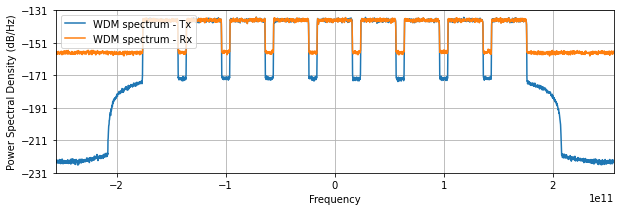

In [58]:
# plota psd
plt.figure()
plt.psd(sigWDM_Tx[:,0], Fs=param.SpS*param.Rs, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=param.SpS*param.Rs, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='upper left')
plt.xlim(-param.SpS*param.Rs/2,param.SpS*param.Rs/2);

FO : -1.2800e+08 Hz
SNR[est] = 15.85 dB 

Total de bits = 58000  
Total de erros contados = 224  
BER = 3.86e-03  


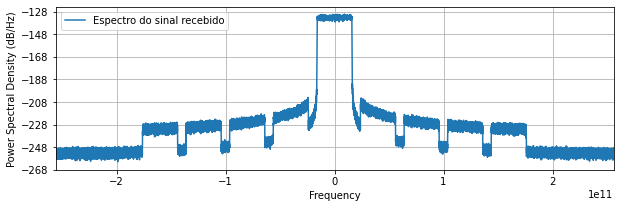

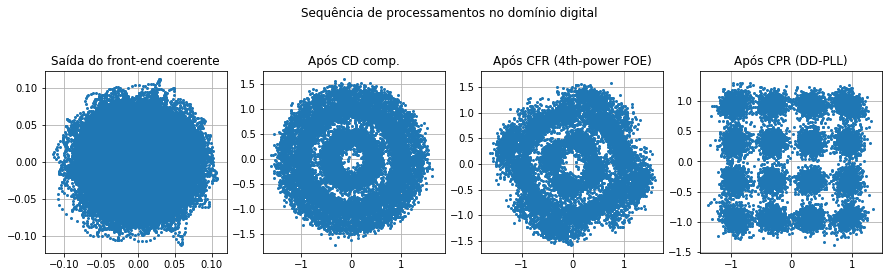

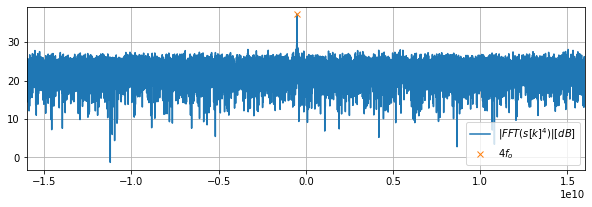

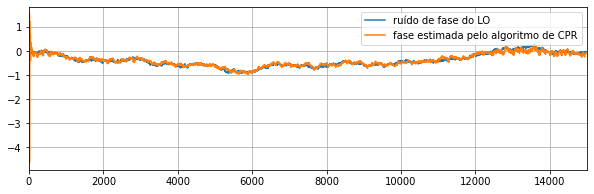

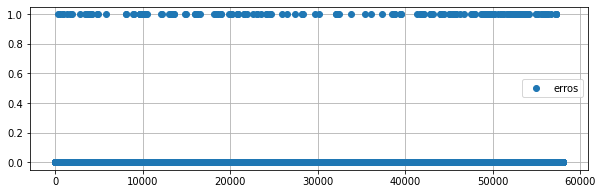

In [59]:
plotPSD = True

Fa = param.SpS*param.Rs
Ta = 1/Fa
mod = QAMModem(m=param.M)

chIndex = 4 # índice do canal a ser demodulado

sigWDM = sigWDM.reshape(len(sigWDM),)
symbTx = symbTx_[:,:,chIndex].reshape(len(symbTx_),)

# Fc do canal a ser demodulado
Δf_lo   = freqGrid[chIndex]+128e6
lw      = 200e3
Plo_dBm = 10 
Plo     = 10**(Plo_dBm/10)*1e-3
ϕ_lo    = 0
π       = np.pi

# gera sinal do oscilador local
t       = np.arange(0, len(sigWDM))*Ta
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ta)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# receptor óptico coerente
sigRx = coherentReceiver(sigWDM, sigLO)

# filtragem Rx

# filtro casado
if param.pulse == 'nrz':
    pulse = pulseShape('nrz', param.SpS)
elif param.pulse == 'rrc':
    pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=1/param.Rs)

pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plota psd
if plotPSD:
    plt.figure();
   # plt.ylim(-250,-50);
    plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal recebido')
    plt.legend(loc='upper left');
    plt.xlim(-Fa/2,Fa/2);

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(15,4.5))
fig.suptitle('Sequência de processamentos no domínio digital')

ax1.plot(sigRx.real, sigRx.imag,'.', markersize=4)
ax1.axis('square')
ax1.title.set_text('Saída do front-end coerente')
ax1.grid()

# digital backpropagation
# hzDBP = 5
# Pin   = 10**(param.Pch_dBm/10)*1e-3
# sigRx = sigRx/np.sqrt(signal_power(sigRx))
# sigRx = dbp(np.sqrt(Pin)*sigRx, Fa, Ltotal, Lspan, hzDBP, alpha, -gamma, D, Fc)
# sigRx = sigRx.reshape(len(sigRx),)
# sigRx = firFilter(pulse, sigRx)
    
# compensação dispersão cromática
sigRx = edc(sigRx, Ltotal, D, Fc-Δf_lo, Fa)

# captura amostras no meio dos intervalos de sinalização
varVector = np.var((sigRx.T).reshape(-1,param.SpS), axis=0) # acha o melhor instante de amostragem
sampDelay = np.where(varVector == np.amax(varVector))[0][0]

# downsampling
sigRx = sigRx[sampDelay::param.SpS]

discard = 1000
ind = np.arange(discard, sigRx.size-discard)

# normaliza símbolos recebidos
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# plota constelação após compensação da dispersão cromática
ax2.plot(sigRx.real, sigRx.imag,'.', markersize=4)
ax2.axis('square')
ax2.title.set_text('Após CD comp.')
ax2.grid()

# calcula atraso gerado pelo walkoff
symbDelay = np.argmax(signal.correlate(np.abs(symbTx), np.abs(sigRx)))-sigRx.size+1 

# compensa atraso do walkoff
sigRx = np.roll(sigRx, symbDelay)

# normaliza constelação recebida
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# estima e compensa desvio de frequência entre sinal e LO
fo = fourthPowerFOE(sigRx, 1/Rs)
print('FO : %3.4e Hz'%fo)

sigRx = sigRx*np.exp(-1j*2*π*fo*np.arange(0,len(sigRx))/Rs)

# plota constelação após compensação do desvio de frequência entre sinal e LO
ax3.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
ax3.axis('square')
ax3.title.set_text('Após CFR (4th-power FOE)')
ax3.grid()

# compensa ruído de fase
windowSize = 40
c  = mod.constellation/np.sqrt(mod.Es)
sigRx, ϕ, θ = CPR(sigRx, windowSize, c, symbTx)

# plota saídas do estimador de fase
phaseOffSet = np.mean(np.roll(ϕ_pn_lo[::param.SpS], symbDelay)-θ)
plt.figure()
plt.plot(np.roll(ϕ_pn_lo[::param.SpS], symbDelay), label='ruído de fase do LO');
plt.plot(θ+phaseOffSet, label='fase estimada pelo algoritmo de CPR');
plt.grid()
plt.xlim(0,θ.size)
plt.legend();

# corrige (possível) ambiguidade de fase adicionada ao sinal
rot = np.mean(symbTx[ind]/sigRx[ind])
sigRx  = rot*sigRx

# normaliza símbolos recebidos
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# plota constelação após compensação do ruído de fase
ax4.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
ax4.axis('square')
ax4.title.set_text('Após CPR (DD-PLL)')
ax4.grid()

# estima SNR da constelação recebida
SNR = signal_power(symbTx[ind])/signal_power(sigRx[ind]-symbTx[ind])

# Demodulação com aplicação a regra de decisão brusca        
bitsRx = mod.demodulate(np.sqrt(mod.Es)*sigRx, demod_type = 'hard') 
bitsTx = mod.demodulate(np.sqrt(mod.Es)*symbTx, demod_type = 'hard') 

err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
                     bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de bits = %d  '%(err.size))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

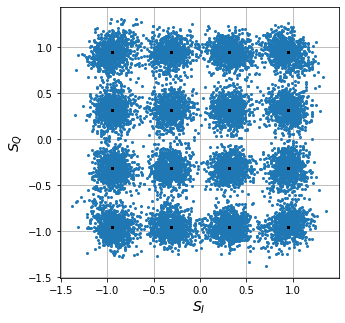

In [60]:
plt.figure(figsize=(5,5))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-1.1,1.1)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx');

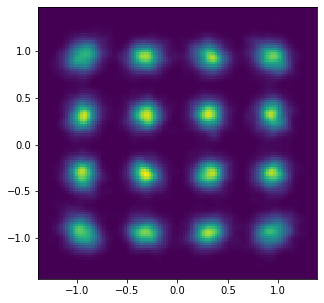

In [547]:
from scipy.stats.kde import gaussian_kde

y = (sigRx[ind]).real
x = (sigRx[ind]).imag

k = gaussian_kde(np.vstack([x, y]))
k.set_bandwidth(bw_method=k.factor/4)

xi, yi = 1.1*np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.figure(figsize=(5,5))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=1, shading='auto');

In [44]:
def dbp(Ein, Fs, Ltotal, Lspan, hz=0.5, alpha=0.2, gamma=1.3, D=16, Fc=193.1e12):      
    '''
    Digital backpropagation (symmetric, single-pol.)
       
    '''             
    c = 299792458   # speed of light (vacuum)
    c_kms = c/1e3
    λ  = c_kms/Fc
    α  = -alpha/(10*np.log10(np.exp(1)))
    β2 = (D*λ**2)/(2*np.pi*c_kms)
    γ  = gamma
            
    Nfft = len(Ein)

    ω = 2*np.pi*Fs*fftfreq(Nfft)
    
    Nspans = int(np.floor(Ltotal/Lspan))
    Nsteps = int(np.floor(Lspan/hz))   
        
    Ech = Ein.reshape(len(Ein),)    
    Ech = fft(Ech) #single-polarization field    
    
    linOperator = np.exp(-(α/2)*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))
        
    for spanN in tqdm(range(0, Nspans)):
        
        Ech = Ech*np.exp((α/2)*Nsteps*hz)
                
        for stepN in range(0, Nsteps):            
            # First linear step (frequency domain)
            Ech = Ech*linOperator            
                      
            # Nonlinear step (time domain)
            Ech = ifft(Ech)
            Ech = Ech*np.exp(1j*γ*(Ech*np.conj(Ech))*hz)
            
            # Second linear step (frequency domain)
            Ech = fft(Ech)       
            Ech = Ech*linOperator             
                
    Ech = ifft(Ech) 
       
    return Ech.reshape(len(Ech), 1)

In [47]:
@numba.njit
def CPR(Ei, N, constSymb, symbTx):    
    '''
    Carrier phase recovery (CPR)
    
    '''    
    ϕ  = np.zeros(Ei.shape)    
    θ  = np.zeros(Ei.shape)
    
    for indSymb in range(0,len(Ei)):
        
        decided = np.argmin(np.abs(Ei[indSymb]*np.exp(1j*θ[indSymb-1]) - constSymb)) # find closest constellation symbol
        
        if indSymb % 50 == 0:
            ϕ[indSymb] = np.angle(symbTx[indSymb]/(Ei[indSymb])) # phase estimation with pilot symbol
        else:
            ϕ[indSymb] = np.angle(constSymb[decided]/(Ei[indSymb])) # phase estimation after symbol decision
                
        if indSymb > N:
            θ[indSymb]  = np.mean(ϕ[indSymb-N:indSymb]) # moving average filter
        else:           
            θ[indSymb] = ϕ[indSymb]
            
    Eo = Ei*np.exp(1j*θ) # compensate phase rotation
        
    return Eo, ϕ, θ

def fourthPowerFOE(Ei, Ts):
    '''
    4th power frequency offset estimator (FOE)
    
    '''
    π = np.pi
    Fs = 1/Ts
    Nfft = len(Ei)
    
    f = Fs*fftfreq(Nfft)
    f = fftshift(f)
    
    f4 = 10*np.log10(np.abs(fftshift(fft(Ei**4))))    
    indFO = np.argmax(f4)
    
    plt.figure()
    plt.plot(f, f4, label = '$|FFT(s[k]^4)|[dB]$')
    plt.plot(f[indFO], f4[indFO],'x',label='$4f_o$')
    plt.legend()
    plt.xlim(min(f), max(f))
    plt.grid()
    
    return f[indFO]/4